In [136]:
import pickle
import os
import pandas as pd
import pandana as pdn
import numpy as np
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

from geopy.distance import geodesic

In [137]:
# Eskuzaitzeta data
trips_ez = pd.read_csv('../input_data/workers_eskuzaitzeta_2k.csv')

In [138]:
eliminar = ['Unnamed: 0', 'Com_Ori', 'Com_Des', 'Modo', 'Municipio', 'Motos','Actividad','Año']
trips_ez = trips_ez.drop(columns=eliminar)
trips_ez

,Mun_Ori,Mun_Des,Hora_Ini,Recur,Per_hog,Turismos,Tipo_familia,Sexo,Edad,crnt_tur,Income,Income_Percentile,O_long,O_lat,D_long,D_lat
0,Donostia/San Sebastian,Errenteria,18:00,22,2,2,2 adultos con niño(s),2,5,1,21756.570,1,-1.951620,43.318235,-2.033693,43.256347
1,Pasaia,Oiartzun,07:45,22,1,2,Hogar de una persona,2,5,1,26603.660,4,-1.922339,43.326542,-2.033693,43.256347
2,Errenteria,Lezo,06:00,22,2,2,2 adultos con niño(s),1,4,1,26210.410,4,-1.902905,43.313945,-2.033693,43.256347
3,Errenteria,Lezo,07:40,22,2,3,Otros hogares con niños,1,5,1,27265.510,4,-1.898167,43.311368,-2.033693,43.256347
4,Andoain,Donostia/San Sebastian,16:05,22,2,2,2 adultos con niño(s),1,5,1,24223.070,2,-2.016226,43.220419,-2.033693,43.256347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,Donostia/San Sebastian,Errenteria,12:30,23,2,2,Otros hogares sin niños,1,5,1,23900.470,2,-1.961791,43.315185,-2.033693,43.256347
2502,Errenteria,Donostia/San Sebastian,08:30,22,2,2,Otros hogares sin niños,2,3,1,18671.675,1,-1.910143,43.313743,-2.033693,43.256347
2503,Donostia/San Sebastian,Hernani,08:00,21,2,2,Otros hogares sin niños,1,5,1,26243.960,4,-2.006557,43.319079,-2.033693,43.256347
2504,Lasarte-Oria,Donostia/San Sebastian,16:15,22,2,3,2 adultos con niño(s),2,4,1,25976.260,3,-2.016131,43.261821,-2.033693,43.256347


In [139]:
# Codify hour manually

# Create a copy column

trips_ez['Hora_Ini_E'] = trips_ez['Hora_Ini'].copy()
cols = list(trips_ez.columns)
A_index = cols.index('Hora_Ini')
cols = cols[:A_index+1] + ['Hora_Ini_E'] + cols[A_index+1:-1]
trips_ez = trips_ez[cols]

# Codify it
trips_ez['Hora_Ini'] = pd.to_datetime(trips_ez['Hora_Ini_E'], format='%H:%M') # Probably the first is Hora_Ini_E

# Calculates difference in minutes from "00:00" and divides by 5
trips_ez['Hora_Ini_E'] = ((trips_ez['Hora_Ini'] - pd.to_datetime('00:00', format='%H:%M')).dt.total_seconds() / 300).astype(int) + 1
trips_ez['Hora_Ini'] = trips_ez['Hora_Ini'].dt.strftime('%H:%M')
trips_ez

,Mun_Ori,Mun_Des,Hora_Ini,Hora_Ini_E,Recur,Per_hog,Turismos,Tipo_familia,Sexo,Edad,crnt_tur,Income,Income_Percentile,O_long,O_lat,D_long,D_lat
0,Donostia/San Sebastian,Errenteria,18:00,217,22,2,2,2 adultos con niño(s),2,5,1,21756.570,1,-1.951620,43.318235,-2.033693,43.256347
1,Pasaia,Oiartzun,07:45,94,22,1,2,Hogar de una persona,2,5,1,26603.660,4,-1.922339,43.326542,-2.033693,43.256347
2,Errenteria,Lezo,06:00,73,22,2,2,2 adultos con niño(s),1,4,1,26210.410,4,-1.902905,43.313945,-2.033693,43.256347
3,Errenteria,Lezo,07:40,93,22,2,3,Otros hogares con niños,1,5,1,27265.510,4,-1.898167,43.311368,-2.033693,43.256347
4,Andoain,Donostia/San Sebastian,16:05,194,22,2,2,2 adultos con niño(s),1,5,1,24223.070,2,-2.016226,43.220419,-2.033693,43.256347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501,Donostia/San Sebastian,Errenteria,12:30,151,23,2,2,Otros hogares sin niños,1,5,1,23900.470,2,-1.961791,43.315185,-2.033693,43.256347
2502,Errenteria,Donostia/San Sebastian,08:30,103,22,2,2,Otros hogares sin niños,2,3,1,18671.675,1,-1.910143,43.313743,-2.033693,43.256347
2503,Donostia/San Sebastian,Hernani,08:00,97,21,2,2,Otros hogares sin niños,1,5,1,26243.960,4,-2.006557,43.319079,-2.033693,43.256347
2504,Lasarte-Oria,Donostia/San Sebastian,16:15,196,22,2,3,2 adultos con niño(s),2,4,1,25976.260,3,-2.016131,43.261821,-2.033693,43.256347


## Change destination to somewhere that is well connected

In [140]:
trips_ez['D_lat'] = '43.305366'
trips_ez['D_long'] = '-2.005843'

## Change origin to a closer place to Eskuzaitzeta

In [141]:
# Read
origins = pd.read_csv('../input_data/origins.csv',index_col=0)

In [142]:
# # Mode 1 of reassigning origin

# possible_towns = ['Donostia/San Sebastian', 'Pasaia', 'Errenteria', 'Andoain',
#        'Urnieta', 'Usurbil', 'Hernani', 'Villabona', 'Lezo', 'Orio', 'Lasarte-Oria', 'Zarautz']
# origins = origins[origins['Town'].isin(possible_towns)]

# def asignar_edificio_aleatorio(row):
#     # Seleccionar un edificio aleatorio
#     idx = np.random.randint(0, len(origins))
#     edificio_seleccionado = origins.iloc[idx]
#     # Asignar latitud y longitud del edificio seleccionado
#     row['O_lat'] = edificio_seleccionado['D_lat']
#     row['O_long'] = edificio_seleccionado['D_long']
#     return row

# trips_ez = trips_ez.apply(asignar_edificio_aleatorio, axis=1)

In [143]:
# Mode 2 of reassigning origin

reference_point = (43.256372, -2.033602)

def calcular_distancia(lat, lon):
    return geodesic(reference_point, (lat, lon)).kilometers

origins['distance'] = origins.apply(lambda x: calcular_distancia(x['D_lat'], x['D_long']), axis=1)
df_edificios_cercanos = origins[origins['distance'] <= 5]

np.random.seed(42)
indices_aleatorios = np.random.choice(df_edificios_cercanos.index, size=len(trips_ez))
# trips_ez['id_edificio_asignado'] = df_edificios_cercanos.loc[indices_aleatorios, 'id'].values
trips_ez['O_lat'] = df_edificios_cercanos.loc[indices_aleatorios, 'D_lat'].values
trips_ez['O_long'] = df_edificios_cercanos.loc[indices_aleatorios, 'D_long'].values

In [108]:
# Mode 3, combination of both

possible_towns = ['Lasarte-Oria']
origins = origins[origins['Town'].isin(possible_towns)]

reference_point = (43.256372, -2.033602)

def calcular_distancia(lat, lon):
    return geodesic(reference_point, (lat, lon)).kilometers

origins['distance'] = origins.apply(lambda x: calcular_distancia(x['D_lat'], x['D_long']), axis=1)
df_edificios_cercanos = origins[origins['distance'] <= 10]

np.random.seed(42)
indices_aleatorios = np.random.choice(df_edificios_cercanos.index, size=len(trips_ez))
# trips_ez['id_edificio_asignado'] = df_edificios_cercanos.loc[indices_aleatorios, 'id'].values
trips_ez['O_lat'] = df_edificios_cercanos.loc[indices_aleatorios, 'D_lat'].values
trips_ez['O_long'] = df_edificios_cercanos.loc[indices_aleatorios, 'D_long'].values

In [ ]:
mapa = folium.Map(location=[trips_ez['O_lat'].mean(), trips_ez['O_long'].mean()], zoom_start=12)

# Añadir puntos al mapa
for _, fila in trips_ez.iterrows():
    folium.Marker(
        location=[fila['O_lat'], fila['O_long']],
        popup=f'Lat: {fila["O_lat"]}, Long: {fila["O_long"]}', # Ejemplo de un popup con info
    ).add_to(mapa)
# mapa

## Add travel times

In [78]:
# # DRIVE

# networks = dict.fromkeys({
#  "walk",
#  "drive",
# })

# for k in networks:
#     print(k)
#     networks[k] = pdn.network.Network.from_hdf5(f'../input_data/networks/{k}_net.h5')

# # # TRANSIT

# transit = dict.fromkeys({
#  "transit_0001",
#  "transit_0102",
#  "transit_0203", # walk_network because transit is not available
#  "transit_0304", # walk_network because transit is not available
#  "transit_0405", # walk_network because transit is not available
#  "transit_0506",
#  "transit_0607",
#  "transit_0708",
#  "transit_0809",
#  "transit_0910",
#  "transit_1011",
#  "transit_1112",
#  "transit_1213",
#  "transit_1314",
#  "transit_1415",
#  "transit_1516",
#  "transit_1617",
#  "transit_1718",
#  "transit_1819",
#  "transit_1920",
#  "transit_2021",
#  "transit_2122",
#  "transit_2223",
#  "transit_2324",
# })

# for k in transit:
#     print(k)
#     transit[k] = pdn.network.Network.from_hdf5(f'../input_data/transit_together_24h/{k}.h5')

In [144]:
# Assign tt

trips_ez["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='drive_time_s'
            )
trips_ez["drive_tt"] = trips_ez["drive_tt"] / 60 # To min

trips_ez["distance"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['drive'].get_node_ids(trips_ez.D_long,trips_ez.D_lat),
            imp_name='distance'
            )

trips_ez["walk_tt"] = networks['walk'].shortest_path_lengths(
            networks['walk'].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            networks['walk'].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
            )
trips_ez["walk_tt"] = trips_ez["walk_tt"] / 60

# Add TRANSIT

for k in transit:
    trips_ez[f"{k}_tt"] = transit[k].shortest_path_lengths(
            transit[k].get_node_ids(trips_ez.O_long,trips_ez.O_lat),
            transit[k].get_node_ids(trips_ez.D_long,trips_ez.D_lat)
    )

def asignar_valor(row):
    if 1 <= row['Hora_Ini_E'] <= 12:
        return row['transit_0001_tt']
    elif 13 <= row['Hora_Ini_E'] <= 24:
        return row['transit_0102_tt']
    elif 25 <= row['Hora_Ini_E'] <= 36:
        return row['transit_0203_tt']
    elif 37 <= row['Hora_Ini_E'] <= 48:
        return row['transit_0304_tt']
    elif 49 <= row['Hora_Ini_E'] <= 60:
        return row['transit_0405_tt']
    elif 61 <= row['Hora_Ini_E'] <= 72:
        return row['transit_0506_tt']
    elif 73 <= row['Hora_Ini_E'] <= 84:
        return row['transit_0607_tt']
    elif 85 <= row['Hora_Ini_E'] <= 96:
        return row['transit_0708_tt']
    elif 97 <= row['Hora_Ini_E'] <= 108:
        return row['transit_0809_tt']
    elif 109 <= row['Hora_Ini_E'] <= 120:
        return row['transit_0910_tt']
    elif 121 <= row['Hora_Ini_E'] <= 132:
        return row['transit_1011_tt']
    elif 133 <= row['Hora_Ini_E'] <= 144:
        return row['transit_1112_tt']
    elif 145 <= row['Hora_Ini_E'] <= 156:
        return row['transit_1213_tt']
    elif 157 <= row['Hora_Ini_E'] <= 168:
        return row['transit_1314_tt']
    elif 169 <= row['Hora_Ini_E'] <= 180:
        return row['transit_1415_tt']
    elif 181 <= row['Hora_Ini_E'] <= 192:
        return row['transit_1516_tt']
    elif 193 <= row['Hora_Ini_E'] <= 204:
        return row['transit_1617_tt']
    elif 205 <= row['Hora_Ini_E'] <= 216:
        return row['transit_1718_tt']
    elif 217 <= row['Hora_Ini_E'] <= 228:
        return row['transit_1819_tt']
    elif 229 <= row['Hora_Ini_E'] <= 240:
        return row['transit_1920_tt']
    elif 241 <= row['Hora_Ini_E'] <= 252:
        return row['transit_2021_tt']
    elif 253 <= row['Hora_Ini_E'] <= 264:
        return row['transit_2122_tt']
    elif 265 <= row['Hora_Ini_E'] <= 276:
        return row['transit_2223_tt']
    elif 277 <= row['Hora_Ini_E'] <= 288:
        return row['transit_2324_tt']
    else:
        return None 

# Create new column
trips_ez['transit_tt_gm'] = trips_ez.apply(asignar_valor, axis=1)

# Don't know why but there are some extreme outliers on drive_tt. 70000 mins?
trips_ez = trips_ez.loc[trips_ez['drive_tt'] < 200].reset_index(drop=True)

trips_ez = trips_ez.drop(columns=['transit_1314_tt',
       'transit_2122_tt', 'transit_1617_tt', 'transit_0405_tt',
       'transit_0001_tt', 'transit_1213_tt', 'transit_1415_tt',
       'transit_0910_tt', 'transit_0708_tt', 'transit_1011_tt',
       'transit_0102_tt', 'transit_1516_tt', 'transit_0506_tt',
       'transit_2021_tt', 'transit_2324_tt', 'transit_1819_tt',
       'transit_0203_tt', 'transit_0809_tt', 'transit_1718_tt',
       'transit_2223_tt', 'transit_0304_tt', 'transit_1920_tt',
       'transit_0607_tt', 'transit_1112_tt'])

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 259730023), (9704972826, 259730023), (2433423935, 259730023)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(9704972826, 259730023), (9704972826, 259730023), (2433423935, 259730023)]
  warnings.warn(
c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(10875865829, 260093639), (10172171307, 260093639), (10875865829, 260093639), (10

In [145]:
trips_ez = trips_ez.loc[trips_ez['transit_tt_gm'] <= 700]
trips_ez = trips_ez.loc[trips_ez['walk_tt'] <= 2000]
trips_ez = trips_ez.reset_index(drop=True)

## Columns encoding

In [146]:
# Codify family type manually

trips_ez['Tipo_familia'].unique()

family = {'Tipo': ['Hogar de una persona', 'Otros hogares sin niños', '2 adultos',
       '2 adultos con niño(s)', '1 adulto con niño(s)',
       'Otros hogares con niños'], 'Codigo': [1, 2, 3, 4, 5, 6]}
family = pd.DataFrame(family)

trips_ez = pd.merge(trips_ez, family, left_on='Tipo_familia', right_on='Tipo', how='left')
trips_ez = trips_ez.drop(columns=['Tipo_familia', 'Tipo'])
trips_ez.rename(columns={'Codigo': 'Tipo_familia'}, inplace=True)

# Codify Mun_Ori y Mun_Des

pueblos = pd.read_excel("../input_data/data_towns.xlsx")
eliminar = ['Region', 'Latitud', 'Longitud', 'Comarca',
       'Altitud (m.s.n.m.)', 'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)',
       'Densidad (hab./kmÂ²)', 'Incluido']
pueblos = pueblos.drop(columns=eliminar)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Ori', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Ori'])
trips_ez.rename(columns={'Código': 'Mun_Ori'}, inplace=True)

trips_ez = pd.merge(trips_ez, pueblos, left_on='Mun_Des', right_on='Town')
trips_ez = trips_ez.drop(columns=['Town', 'Mun_Des'])
trips_ez.rename(columns={'Código': 'Mun_Des'}, inplace=True)

# Predict

In [126]:
model_name = "rf"  # El nombre del modelo que guardaste anteriormente
file_path = os.path.join("models", f'{model_name}.pkl')

with open(file_path, 'rb') as file:
    model = pickle.load(file)

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


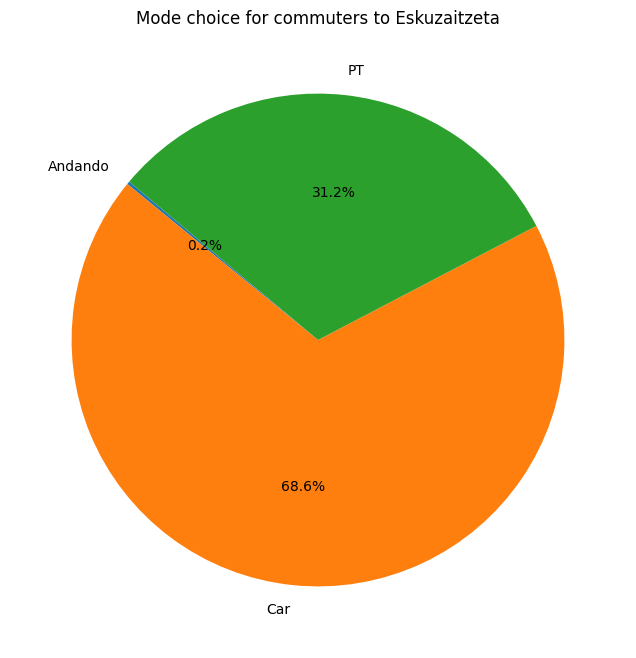

In [147]:
x = np.array(trips_ez.drop(columns = ['Hora_Ini', 'Recur', 'Income', 'Income_Percentile', 'Mun_Des', 'Mun_Ori', 'O_long', 'O_lat', 'D_long', 'D_lat']))
y_pred = model.predict(x)

unique_labels, counts = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Mode choice for commuters to Eskuzaitzeta')
plt.show()

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


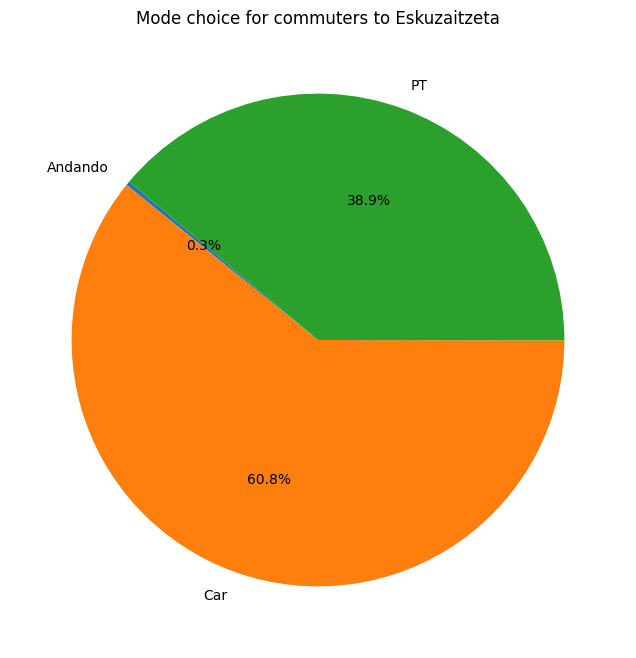

In [148]:
# REDUCE TRANSIT TRAVEL TIME

trips_ez_1 = trips_ez.copy()
# trips_ez_1['drive_tt'] = trips_ez_1['drive_tt'] * 1.5
# trips_ez_1['distance'] = trips_ez_1['distance'] * 1.5
trips_ez_1['transit_tt_gm'] = trips_ez_1['transit_tt_gm'] * 0.7

# trips_ez_1['Per_hog'] = 1
# trips_ez_1['Sexo'] = 2
# trips_ez_1['Turismos'] = 1
# trips_ez_1['crnt_tur'] = 2
# trips_ez_1['Tipo_familia'] = 3

x = np.array(trips_ez_1.drop(columns = ['Hora_Ini', 'Recur', 'Income', 'Income_Percentile', 'Mun_Des', 'Mun_Ori', 'O_long', 'O_lat', 'D_long', 'D_lat']))
y_pred_1 = model.predict(x)

unique_labels, counts = np.unique(y_pred_1, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Mode choice for commuters to Eskuzaitzeta')
plt.show()

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


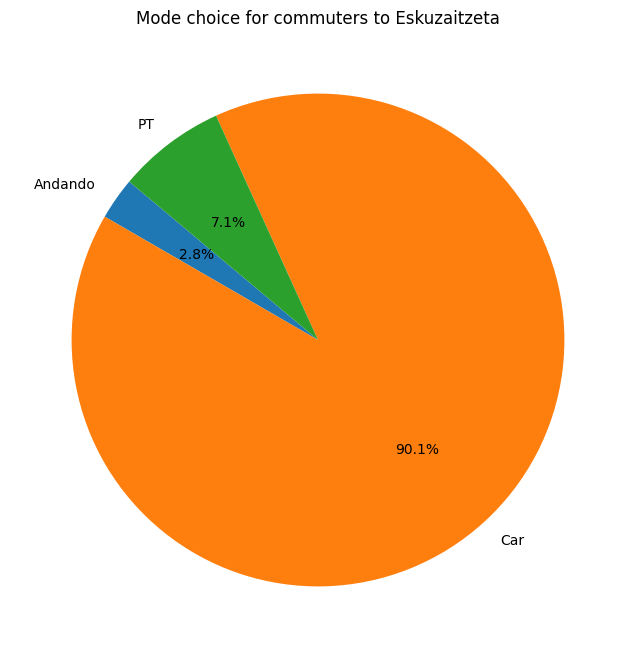

In [107]:
# ATTACK CAR OWNERSHIP. CASI NINGÚN EFECTO

trips_ez_2 = trips_ez.copy()
condition = trips_ez_2['Turismos'].isin([2, 3, 4])

# Paso 2: Seleccionar aleatoriamente el 80% de esas filas
modify_rows = trips_ez_2[condition].sample(frac=1, random_state=42)

# Paso 3: Modificar el valor de 'crnt_tur' a 0 para las filas seleccionadas
trips_ez_2.loc[modify_rows.index, 'Turismos'] = 1

x = np.array(trips_ez_2)
y_pred_2 = model.predict(x)

unique_labels, counts = np.unique(y_pred_2, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique_labels, autopct='%1.1f%%', startangle=140)
plt.title('Mode choice for commuters to Eskuzaitzeta')
plt.show()

In [108]:
trips_ez_2['Turismos'].value_counts()

Turismos
1    2494
Name: count, dtype: int64

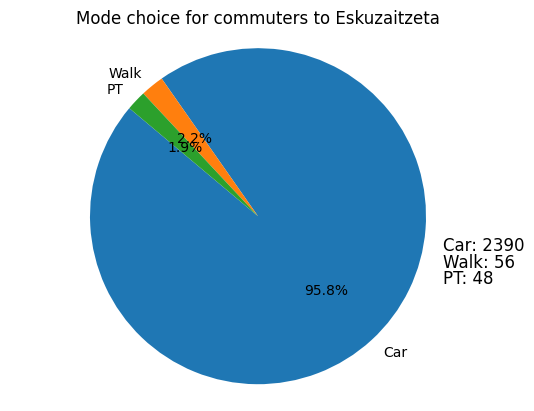

In [48]:
# Contar la frecuencia de cada tipo de valor
from collections import Counter
value_counts = Counter(y_pred)

# Extraer las etiquetas y sus frecuencias
labels, counts = zip(*value_counts.items())

custom_labels = ['Car', 'Walk', 'PT']  # Reemplaza estos nombres según tus necesidades

# Crear un gráfico de pastel
plt.pie(counts, labels=custom_labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Para asegurarse de que el gráfico de pastel sea circular
plt.title('Mode choice for commuters to Eskuzaitzeta')

# Agregar el número total de cada categoría
for i, label in enumerate(custom_labels):
    plt.text(1.1, -0.2 - 0.1 * i, f'{label}: {counts[i]}', fontsize=12)

# Mostrar el gráfico
plt.show()